<h1 align="center">Hacettepe University <br> Department of Computer Science </h1> 

<h2 align="center">BBM 415 - Fundamentals of Image Processing Laboratory<br>2022 Fall</h2>

<h3 align="center">Assignment 4</h3>
<h3 align="left">Name    :    Murat Çelik</h3>
<h3 align="left">ID      :    21827263</h3>
<h4 align="right">Due on January 07, 2023</h4>

# Introduction

Before the existence of Deep Learning, different techniques were used for image classification. One of them is to search a part of a picture in the other picture with the sliding windows algorithm with different techniques. The general name of this problem is called template matching.

One of these techniques is the normalized cross correlation method. Today I will solve the classification problem with NCC using American Sign Language data. Below I have put into the NCC algorithm for all images with each template image. This algorithm finds and scores the best match between two images. After finding the best window, I assigned a score for each template. Then I chose the best score to determine which template was closest for that image. Thus, the best result of our picture was from the class of that template.

The experiment was carried out with templates in 26 different classes on 780 pictures. Below we can see the code of these stages, the overall score and results.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
print(os.listdir())
os.chdir("drive/MyDrive/4th_Grade/Fall/BBM415/Ass4")

['.config', 'drive', 'sample_data']


In [ ]:
import cv2 as cv
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd

In [ ]:
# implement your normalized cross correlation method.
def normalize_data(data):
    # normalize data to have mean=0 and standard_deviation=1
    mean_data=np.mean(data)
    std_data=np.std(data, ddof=1)
    return (data-mean_data)/(std_data)

def ncc(img1, img2):
    return (1.0/(img1.size-1)) * np.sum(normalize_data(img1)*normalize_data(img2))

In [ ]:
try:
    os.mkdir("preds")
except:
    print("File exist")
df = pd.DataFrame(columns=["Path","Preds","Label"])

for letter in os.listdir("dataset/target"): # For every letter in target folder
    try:
        os.mkdir("preds/" + letter)
    except:
        pass
    preds = []
    y_true = []
    for letter_img in os.listdir("dataset/target/" + letter): # for every image in specific letter folder
        df_row = dict()
        img = cv.imread(f"dataset/target/{letter}/{letter_img}",0)
        df_row["Path"] = f"dataset/target/{letter}/{letter_img}"
        df_row["Label"] = letter
        y_true.append(letter)
        all_scenario = dict() # obtain the offsets and the peak signals.
        x_list = np.linspace(0, 15, num=50,dtype=int).tolist() # Search 50 different x value
        y_list = np.linspace(0, 50, num=50,dtype=int).tolist() # Search 50 different y value,
        for pred_letter in os.listdir("dataset/template"): # compare the peak signals for each template
            template = cv.imread("dataset/template/" + pred_letter,0)
            template = cv.resize(template, (150,185), interpolation = cv.INTER_AREA)
            normcc = dict()
            for x in x_list: # So search 250 different combinations on image
                for y in y_list:
                    img_tmp = img[x:x+185,y:y+150]
                    score = ncc(img_tmp,template) #Calculate the cross correlation
                    normcc[(x,y)] = score
            all_scenario[pred_letter] = normcc   # all score is saved 
        best_scenario = dict()
        for k,v in all_scenario.items(): # Choose the maximum peak and coordinates in one letter(template) data
            k = k.split(".")[0]
            best_x,best_y = 0,0
            best_score = 0
            for k1,v1 in v.items():
                if v1 > best_score:
                    best_x,best_y = k1
                    best_score = v1
            best_scenario[k] = (best_x,best_y,best_score) 
        coord = []
        scores = []
        keys = []
        for k,v in best_scenario.items(): # Choose the maximum peak and coordinates in all letters(template)
            x,y,s = v
            keys.append(k)
            coord.append((x,y))
            scores.append(s)
        coord = np.array(coord)
        keys = np.array(keys)
        T = coord[list(np.argsort(scores))]
        K = keys[list(np.argsort(scores))]
        y_o,x_o = T[-1]
        label = K[-1]  
        preds.append(label)  # classify the target with respect to the maximum peak of the template
        df_row["Preds"] = label
        df = df.append(df_row,ignore_index=True)
        df.to_csv("report.csv",index=False) # save actual values and estimated values of all images
        img_tmp = img.copy()
        cv.rectangle(img_tmp,(y_o,x_o), (y_o+150,x_o+185), 255, 2) # place the best template on the pictures
        cv.imwrite(f"preds/{letter}/{letter_img}", img_tmp) #save all images to file


In [ ]:
# All records are attached to a csv file. We'll review the results below.

In [ ]:
df = pd.read_csv("NCC_predict.csv")
y_true = df["Label"]
y_pred = df["Preds"]

The success rate is seen as 10%. It can be said that the results are quite behind compared to today's algorithms. It can be said that this algorithm gives better results than expected for the old periods.

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
accuracy_score(y_true, y_pred)

0.09743589743589744

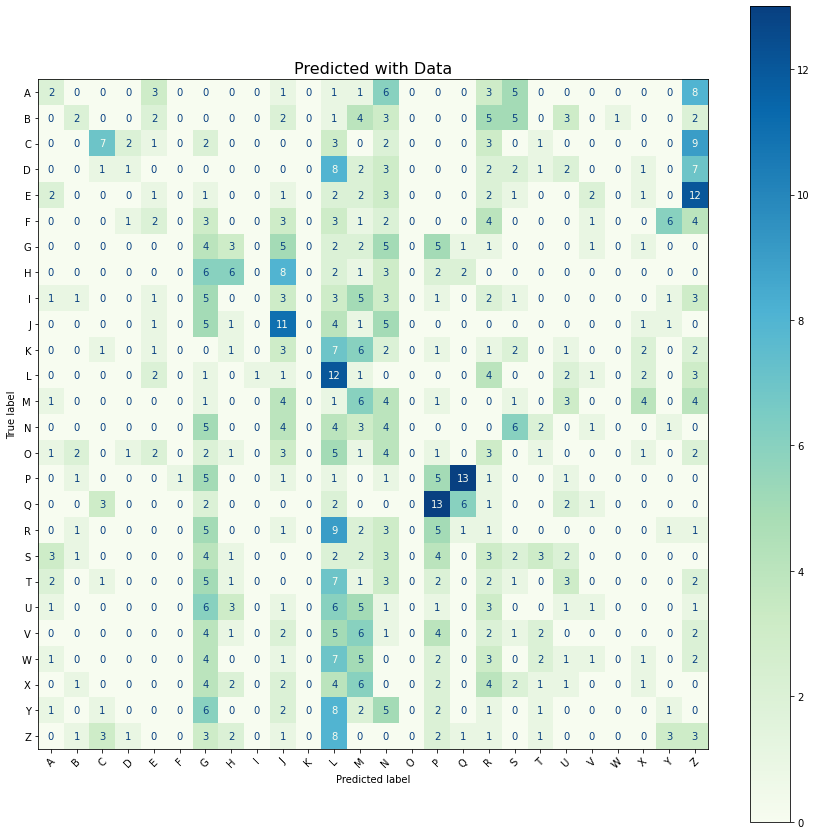

In [ ]:
keys = sorted(list(set(y_true)))

cm_train = confusion_matrix(y_true, y_pred,labels=keys)

disp = ConfusionMatrixDisplay(confusion_matrix=cm_train, display_labels=keys)
fig, ax1 = plt.subplots(1, 1, figsize = (15, 15))
disp.plot(ax=ax1, cmap='GnBu')
ax1.tick_params(axis='x', labelrotation=45)
ax1.set_title('Predicted with Data', fontsize=16)
plt.show()

It is observed that the classes G, L, P, Q, Z are the most mentioned classes in estimation. The main reason for this is likely to be due to the proximity of the letters to each other.

It is observed that there are 13 matches each due to the similarities between the P and Q data. But when you look at it, the prediction of Q as Q appears to be 6 predicts. This can be explained by the fact that the signs are similar to each other.

Again, it seems that the letter E is less predicts. The main reason for this is that the fingers are not used in the letter E representation, which shows that it is difficult to distinguish.

In [ ]:
def predict_finder(letter,num):
    return df[df["Path"] == f"dataset/target/{letter}/{letter}{num}.jpg"]["Preds"].values[0]

Text(0.5, 1.0, 'Actual : Z - Predicted : C ')

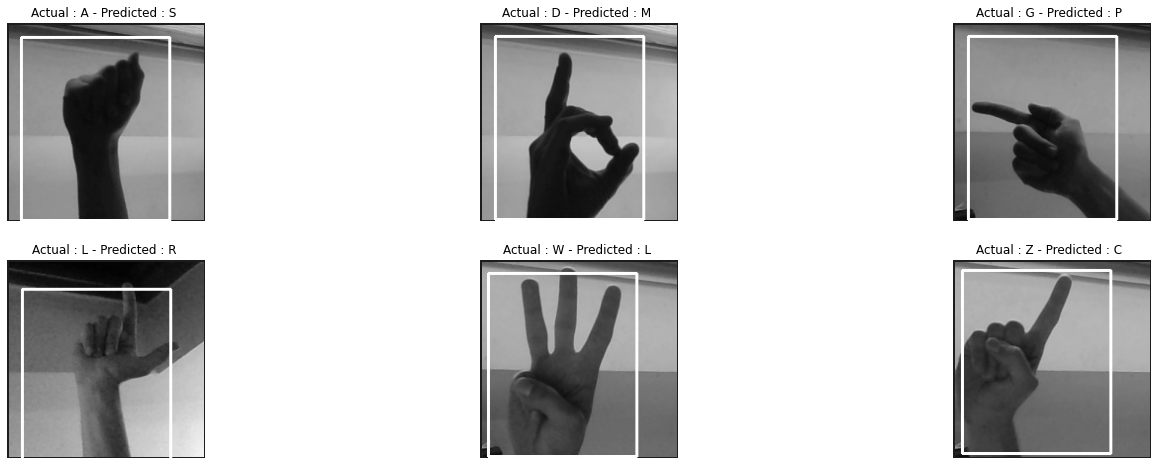

In [ ]:
fig = plt.figure(figsize=(24, 8))
rows = 2
columns = 3

letter1 = "A"; Image1 = cv.imread(f'NCC_Output/{letter1}/{letter1}1.jpg'); p1 = predict_finder(letter1,"1")
letter2 = "D"; Image2 = cv.imread(f'NCC_Output/{letter2}/{letter2}1.jpg'); p2 = predict_finder(letter2,"1")
letter3 = "G"; Image3 = cv.imread(f'NCC_Output/{letter3}/{letter3}1.jpg'); p3 = predict_finder(letter3,"1")
letter4 = "L"; Image4 = cv.imread(f'NCC_Output/{letter4}/{letter4}2001.jpg'); p4 = predict_finder(letter4,"2001")
letter5 = "W"; Image5 = cv.imread(f'NCC_Output/{letter5}/{letter5}1.jpg'); p5 = predict_finder(letter5,"1")
letter6 = "Z"; Image6 = cv.imread(f'NCC_Output/{letter6}/{letter6}1.jpg'); p6 = predict_finder(letter6,"1")

fig.add_subplot(rows, columns, 1)
plt.imshow(Image1)
plt.axis('off')
plt.title(f"Actual : {letter1} - Predicted : {p1} ")

fig.add_subplot(rows, columns, 2)
plt.imshow(Image2)
plt.axis('off')
plt.title(f"Actual : {letter2} - Predicted : {p2} ")

fig.add_subplot(rows, columns, 3)
plt.imshow(Image3)
plt.axis('off')
plt.title(f"Actual : {letter3} - Predicted : {p3} ")

fig.add_subplot(rows, columns, 4)
plt.imshow(Image4)
plt.axis('off')
plt.title(f"Actual : {letter4} - Predicted : {p4} ")

fig.add_subplot(rows, columns, 5)
plt.imshow(Image5)
plt.axis('off')
plt.title(f"Actual : {letter5} - Predicted : {p5} ")

fig.add_subplot(rows, columns, 6)
plt.imshow(Image6)
plt.axis('off')
plt.title(f"Actual : {letter6} - Predicted : {p6} ")


We see the wrong results above. There can be many reasons for getting an error. One of them may be the contrast difference between the main image and the template. Different options may have been estimated due to the shape of the sign. There may have been distortions in the estimation due to the lack of sharp distinctions between the background and the hand. It is normal to draw wrong conclusions for such reasons. It is a difficult problem for the computer to find the difference between the pictures, which are made up of 0s and 1s. Being able to solve this problem with a certain success with image matching is also fruitful.

Text(0.5, 1.0, 'Actual : H - Predicted : H ')

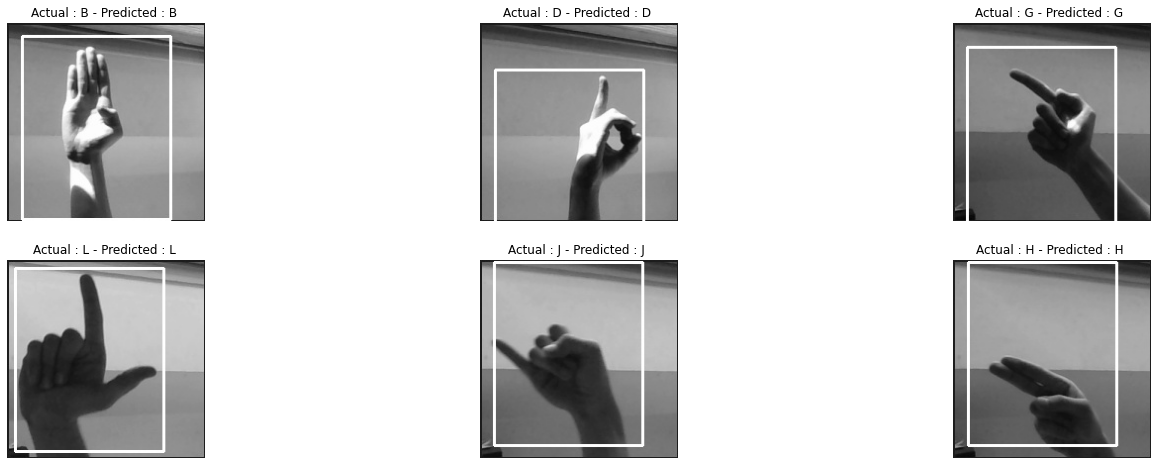

In [ ]:
fig = plt.figure(figsize=(24, 8))
rows = 2
columns = 3

letter1 = "B"; Image1 = cv.imread(f'NCC_Output/{letter1}/{letter1}601.jpg'); p1 = predict_finder(letter1,"601")
letter2 = "D"; Image2 = cv.imread(f'NCC_Output/{letter2}/{letter2}401.jpg'); p2 = predict_finder(letter2,"401")
letter3 = "G"; Image3 = cv.imread(f'NCC_Output/{letter3}/{letter3}901.jpg'); p3 = predict_finder(letter3,"901")
letter4 = "L"; Image4 = cv.imread(f'NCC_Output/{letter4}/{letter4}1.jpg'); p4 = predict_finder(letter4,"1")
letter5 = "J"; Image5 = cv.imread(f'NCC_Output/{letter5}/{letter5}301.jpg'); p5 = predict_finder(letter5,"301")
letter6 = "H"; Image6 = cv.imread(f'NCC_Output/{letter6}/{letter6}801.jpg'); p6 = predict_finder(letter6,"801")
fig.add_subplot(rows, columns, 1)
plt.imshow(Image1)
plt.axis('off')
plt.title(f"Actual : {letter1} - Predicted : {p1} ")

fig.add_subplot(rows, columns, 2)
plt.imshow(Image2)
plt.axis('off')
plt.title(f"Actual : {letter2} - Predicted : {p2} ")

fig.add_subplot(rows, columns, 3)
plt.imshow(Image3)
plt.axis('off')
plt.title(f"Actual : {letter3} - Predicted : {p3} ")

fig.add_subplot(rows, columns, 4)
plt.imshow(Image4)
plt.axis('off')
plt.title(f"Actual : {letter4} - Predicted : {p4} ")

fig.add_subplot(rows, columns, 5)
plt.imshow(Image5)
plt.axis('off')
plt.title(f"Actual : {letter5} - Predicted : {p5} ")

fig.add_subplot(rows, columns, 6)
plt.imshow(Image6)
plt.axis('off')
plt.title(f"Actual : {letter6} - Predicted : {p6} ")


Above we see the correct results. There are certain reasons why the results are correct. When we first examine the pictures above, it can be said that good results are obtained with the contrast difference between the hand and the background. Another reason is that letters have a unique structure. For example, the letters H and L have a different structure from other letters. Results within 10% success can be observed in this way.

## Histogram of Oriented Gradients (HOG)

The histogram of oriented gradients (HOG) is a feature descriptor used in computer vision and image processing for the purpose of object detection. The technique counts occurrences of gradient orientation in localized portions of an image.

In [ ]:
from skimage.feature import hog

Text(0.5, 1.0, 'Binary Image After HOG')

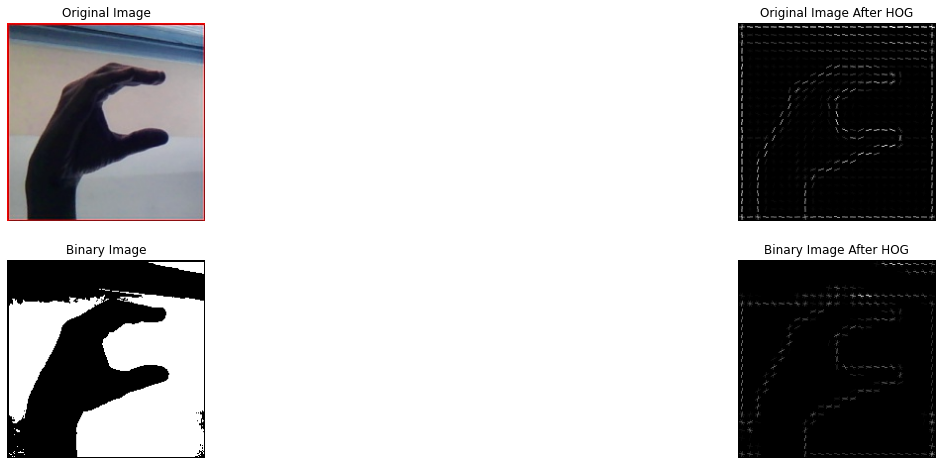

In [ ]:
fig = plt.figure(figsize=(24, 8))
rows = 2
columns = 2
letter = "C"
img = cv.imread(f'dataset/target/{letter}/{letter}1.jpg')

fd, hog_image_from_img = hog(img, orientations=8, pixels_per_cell=(8, 8),cells_per_block=(2, 2), visualize=True, multichannel=True)

im_gray = cv.imread(f'dataset/target/{letter}/{letter}1.jpg', cv.IMREAD_GRAYSCALE)
thresh = 150
im_bw = cv.threshold(im_gray, thresh, 255, cv.THRESH_BINARY)[1]

fd, hog_image_from_im_bw = hog(im_bw, orientations=8, pixels_per_cell=(8, 8),cells_per_block=(2, 2), visualize=True, multichannel=False)


fig.add_subplot(rows, columns, 1)
plt.imshow(img)
plt.axis('off')
plt.title(f"Original Image")

fig.add_subplot(rows, columns, 2)
plt.imshow(hog_image_from_img,cmap="gray")
plt.axis('off')
plt.title(f"Original Image After HOG")

fig.add_subplot(rows, columns, 3)
plt.imshow(im_bw,cmap="gray")
plt.axis('off')
plt.title(f"Binary Image")

fig.add_subplot(rows, columns, 4)
plt.imshow(hog_image_from_im_bw,cmap="gray")
plt.axis('off')
plt.title(f"Binary Image After HOG")


HOG calculation is performed on all images. Another classification is made with the results. Above is a test to see if the original image should be converted to binary image before HOG calculation. It was decided to make it with the original image.

In [ ]:
from skimage.feature import hog
try:
    os.mkdir("HOG")
except:
    pass
for letter in os.listdir("dataset/target"):
    try:
        os.mkdir(f"HOG/{letter}")
    except:
        pass
    for letter_img in os.listdir(f"dataset/target/{letter}"):
        img = cv.imread(f'dataset/target/{letter}/{letter_img}')
        fd, hog_image = hog(img, orientations=8, pixels_per_cell=(8, 8),cells_per_block=(2, 2), visualize=True, multichannel=True)
        cv.imwrite(f"HOG/{letter}/{letter_img}", hog_image) 


In [ ]:
try:
    os.mkdir("HOG_template")
except:
    pass
for letter_img in os.listdir("dataset/template"):
    img = cv.imread(f'dataset/template/{letter_img}')
    fd, hog_image = hog(img, orientations=8, pixels_per_cell=(8, 8),cells_per_block=(2, 2), visualize=True, multichannel=True)
    cv.imwrite(f"HOG_template/{letter_img}", hog_image) 

Problem Loop:

In [ ]:
try:
    os.mkdir("preds")
except:
    print("File exist")
df = pd.DataFrame(columns=["Path","Preds","Label"])

for letter in ["Q","R","S","T","U","V","W","X","Y","Z"]: # os.listdir("dataset/target"): # For every letter in target folder
    try:
        os.mkdir("preds/" + letter)
    except:
        pass
    preds = []
    y_true = []
    for letter_img in os.listdir("HOG/" + letter): # for every image in specific HOG folder
        df_row = dict()
        img = cv.imread(f"HOG/{letter}/{letter_img}",0)
        df_row["Path"] = f"HOG/{letter}/{letter_img}"
        df_row["Label"] = letter
        y_true.append(letter)
        all_scenario = dict() # obtain the offsets and the peak signals.
        x_list = np.linspace(0, 15, num=50,dtype=int).tolist() # Search 50 different x value
        y_list = np.linspace(0, 50, num=50,dtype=int).tolist() # Search 50 different y value,
        for pred_letter in os.listdir("HOG_template"): # compare the peak signals for each template
            template = cv.imread("HOG_template/" + pred_letter,0)
            template = cv.resize(template, (150,185), interpolation = cv.INTER_AREA)
            normcc = dict()
            for x in x_list: # So search 250 different combinations on image
                for y in y_list:
                    img_tmp = img[x:x+185,y:y+150]
                    score = ncc(img_tmp,template) #Calculate the cross correlation
                    normcc[(x,y)] = score
            all_scenario[pred_letter] = normcc   # all score is saved 
        best_scenario = dict()
        for k,v in all_scenario.items(): # Choose the maximum peak and coordinates in one letter(template) data
            k = k.split(".")[0]
            best_x,best_y = 0,0
            best_score = 0
            for k1,v1 in v.items():
                if v1 > best_score:
                    best_x,best_y = k1
                    best_score = v1
            best_scenario[k] = (best_x,best_y,best_score) 
        coord = []
        scores = []
        keys = []
        for k,v in best_scenario.items(): # Choose the maximum peak and coordinates in all letters(template)
            x,y,s = v
            keys.append(k)
            coord.append((x,y))
            scores.append(s)
        coord = np.array(coord)
        keys = np.array(keys)
        T = coord[list(np.argsort(scores))]
        K = keys[list(np.argsort(scores))]
        y_o,x_o = T[-1]
        label = K[-1]  
        preds.append(label)  # classify the target with respect to the maximum peak of the template
        df_row["Preds"] = label
        df = df.append(df_row,ignore_index=True)
        df.to_csv("report.csv",index=False) # save actual values and estimated values of all images
        img_tmp = img.copy()
        cv.rectangle(img_tmp,(y_o,x_o), (y_o+150,x_o+185), 255, 2) # place the best template on the pictures
        cv.imwrite(f"preds/{letter}/{letter_img}", img_tmp) #save all images to file

### HOG Results

In [ ]:
df = pd.read_csv("HOG_predict.csv")
y_true = df["Label"]
y_pred = df["Preds"]

We can see that the success has decreased from 10% to 7%. We can say that the processing speed has decreased, but at this point, success is more important.

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
accuracy_score(y_true, y_pred)


0.06666666666666667

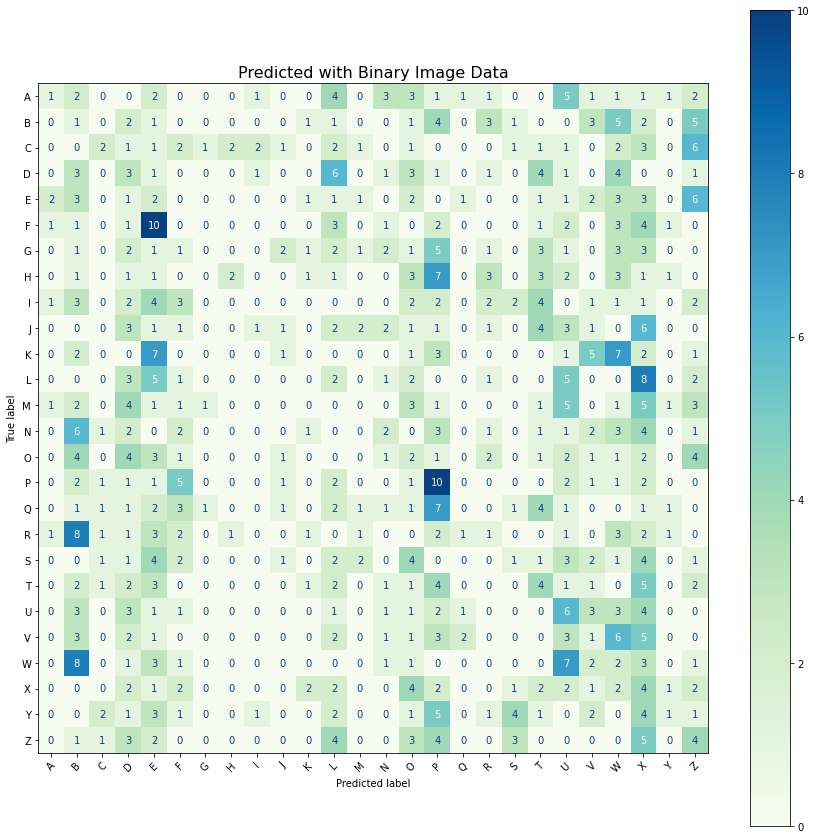

In [ ]:
keys = sorted(list(set(y_true)))

cm_train = confusion_matrix(y_true, y_pred,labels=keys)

disp = ConfusionMatrixDisplay(confusion_matrix=cm_train, display_labels=keys)
fig, ax1 = plt.subplots(1, 1, figsize = (15, 15))
disp.plot(ax=ax1, cmap='GnBu')
ax1.tick_params(axis='x', labelrotation=45)
ax1.set_title('Predicted with Binary Image Data', fontsize=16)
plt.show()

It seems that the estimates are directed towards 5 letters. "D,E,P,W,X". The reason for the general success here is that the contrast difference in the picture is proportional to the effect on the gradients.

Text(0.5, 1.0, 'Actual : Z - Predicted : Z ')

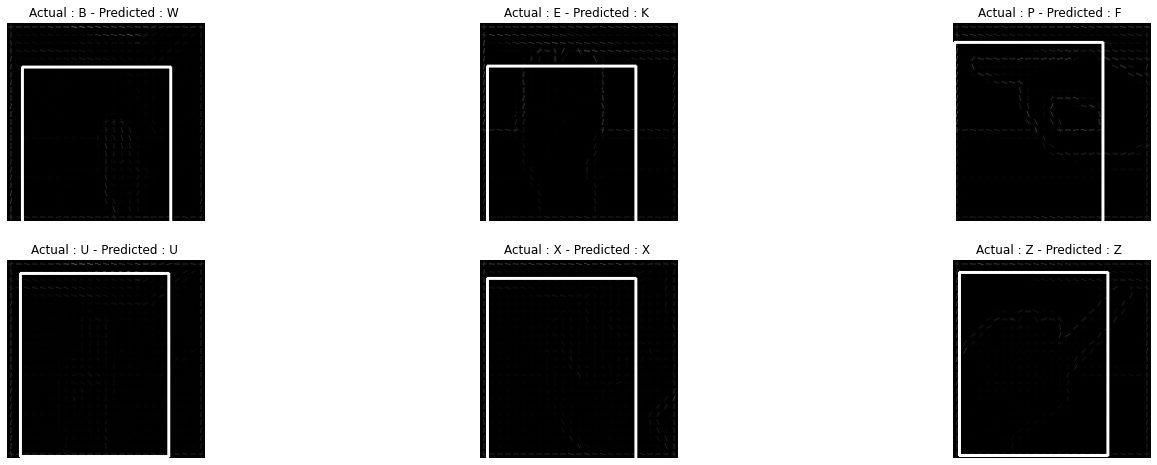

In [ ]:
def predict_finder(letter,num):
    return df[df["Path"] == f"HOG/{letter}/{letter}{num}.jpg"]["Preds"].values[0]

fig = plt.figure(figsize=(24, 8))
rows = 2
columns = 3

letter1 = "B"; Image1 = cv.imread(f'HOG_Output/{letter1}/{letter1}1501.jpg'); p1 = predict_finder(letter1,"1501")
letter2 = "E"; Image2 = cv.imread(f'HOG_Output/{letter2}/{letter2}2501.jpg'); p2 = predict_finder(letter2,"2501")
letter3 = "P"; Image3 = cv.imread(f'HOG_Output/{letter3}/{letter3}2901.jpg'); p3 = predict_finder(letter3,"2901")
letter4 = "U"; Image4 = cv.imread(f'HOG_Output/{letter4}/{letter4}1101.jpg'); p4 = predict_finder(letter4,"1101")
letter5 = "X"; Image5 = cv.imread(f'HOG_Output/{letter5}/{letter5}2301.jpg'); p5 = predict_finder(letter5,"2301")
letter6 = "Z"; Image6 = cv.imread(f'HOG_Output/{letter6}/{letter6}201.jpg'); p6 = predict_finder(letter6,"201")
fig.add_subplot(rows, columns, 1)
plt.imshow(Image1)
plt.axis('off')
plt.title(f"Actual : {letter1} - Predicted : {p1} ")

fig.add_subplot(rows, columns, 2)
plt.imshow(Image2)
plt.axis('off')
plt.title(f"Actual : {letter2} - Predicted : {p2} ")

fig.add_subplot(rows, columns, 3)
plt.imshow(Image3)
plt.axis('off')
plt.title(f"Actual : {letter3} - Predicted : {p3} ")

fig.add_subplot(rows, columns, 4)
plt.imshow(Image4)
plt.axis('off')
plt.title(f"Actual : {letter4} - Predicted : {p4} ")

fig.add_subplot(rows, columns, 5)
plt.imshow(Image5)
plt.axis('off')
plt.title(f"Actual : {letter5} - Predicted : {p5} ")

fig.add_subplot(rows, columns, 6)
plt.imshow(Image6)
plt.axis('off')
plt.title(f"Actual : {letter6} - Predicted : {p6} ")


# Conclusion

We have come to a position where we can easily solve many different problems with artificial intelligence technology. By spending less time than the problem we have tested above, we could go to the solution with algorithms with near-perfect results. The value of old work comes from the fact that it is the basis of new work. Thus, with a solid basic knowledge, we have the chance to think more broadly for the solution of these technologies. Thus, we experienced both the importance of image processing and its use.

# References 

- [Template Matching](https://docs.opencv.org/4.x/d4/dc6/tutorial_py_template_matching.html)
- [Histogram of oriented gradients](https://en.wikipedia.org/wiki/Histogram_of_oriented_gradients)